# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [28]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [6]:
# open air temp dataset
air = xr.open_dataset(TEMP_URL, chunks={"time": 8})["air"]
air = air.sel(lat=slice(*LAT_RANGE[::-1]),
              lon=slice(*LON_RANGE_360),
              time=TIME_RANGE)

# open precip dataset
precip = xr.open_dataset(PRECIP_URL, chunks={"time": 8})["precip"]
precip = precip.assign_coords(
    lon=((precip.lon % 360))
) # adjust lon coord
precip = precip.sel(lat=slice(*LAT_RANGE[::-1]),
                    lon=slice(*LON_RANGE_360),
                    time=TIME_RANGE)

print(air)
print(precip)

<xarray.DataArray 'air' (time: 120, lat: 13, lon: 29)> Size: 181kB
dask.array<getitem, shape=(120, 13, 29), dtype=float32, chunksize=(8, 13, 29), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]
<xarray.DataArray 'precip' (time: 30, lat: 60, lon: 140)> Size: 1MB
dask.array<getitem, shape=(30, 60, 140), dtype=float32, chunksize=(8, 60, 140), chunktype=num

## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [7]:
air_us = air.sel(lon=slice(230,300),
                 time="2020-06")

precip_us = precip.sel(lon=slice(230,300),
                       time="2020-06")

print(air_us)
print(precip_us)

<xarray.DataArray 'air' (time: 120, lat: 13, lon: 29)> Size: 181kB
dask.array<getitem, shape=(120, 13, 29), dtype=float32, chunksize=(8, 13, 29), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 960B 2020-06-01 ... 2020-06-30T18:00:00
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]
<xarray.DataArray 'precip' (time: 30, lat: 60, lon: 140)> Size: 1MB
dask.array<getitem, shape=(30, 60, 140), dtype=float32, chunksize=(8, 60, 140), chunktype=num

## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [8]:
air_daily = air_us.resample(time="1D").mean()
print(air_daily)

<xarray.DataArray 'air' (time: 30, lat: 13, lon: 29)> Size: 45kB
dask.array<stack, shape=(30, 13, 29), dtype=float32, chunksize=(1, 13, 29), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 52B 50.0 47.5 45.0 42.5 40.0 ... 27.5 25.0 22.5 20.0
  * lon      (lon) float32 116B 230.0 232.5 235.0 237.5 ... 295.0 297.5 300.0
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [9]:
air_interp = air_daily.interp(lat=precip_us.lat, lon=precip_us.lon)
print(air_interp)

<xarray.DataArray 'air' (time: 30, lat: 60, lon: 140)> Size: 1MB
dask.array<transpose, shape=(30, 60, 140), dtype=float32, chunksize=(1, 60, 140), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    actual_range:  [188.6 324.1]
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]


## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [10]:
# build two datasets then merge
air_ds = xr.Dataset({"air_temperature": air_interp})
precip_ds = xr.Dataset({"daily_precip": precip_us})
merged = xr.merge([air_ds, precip_ds])
print(merged)

<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>


## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [11]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air_temperature", "daily_precip"}
assert merged.air_temperature.dims == merged.daily_precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:          (time: 30, lat: 60, lon: 140)
Coordinates:
  * time             (time) datetime64[ns] 240B 2020-06-01 ... 2020-06-30
  * lat              (lat) float32 240B 49.75 49.25 48.75 ... 21.25 20.75 20.25
  * lon              (lon) float32 560B 230.2 230.8 231.2 ... 298.8 299.2 299.8
Data variables:
    air_temperature  (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    daily_precip     (time, lat, lon) float32 1MB dask.array<chunksize=(8, 60, 140), meta=np.ndarray>


## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


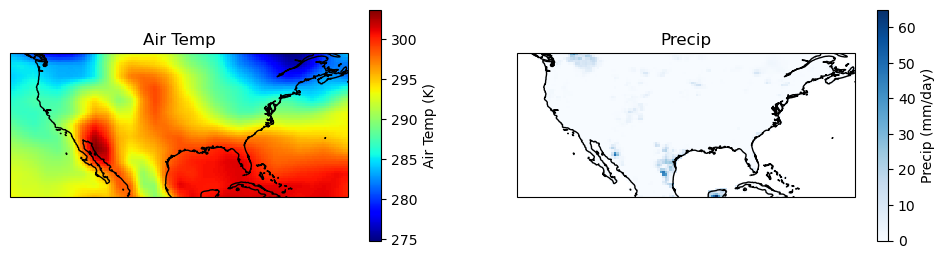

In [22]:
# plot map
fig, axs = plt.subplots(1, 2, figsize=(12, 3),
                        subplot_kw={"projection": ccrs.PlateCarree()})

merged.air_temperature.isel(time=0).plot(
    ax=axs[0], transform=ccrs.PlateCarree(),
    cmap="jet", cbar_kwargs={"label": "Air Temp (K)"},
)
axs[0].coastlines()
axs[0].set_title(f"Air Temp")

merged.daily_precip.isel(time=0).plot(
    ax=axs[1], transform=ccrs.PlateCarree(),
    cmap="Blues", cbar_kwargs={"label": "Precip (mm/day)"}
)
axs[1].coastlines()
axs[1].set_title(f"Precip")
plt.show()

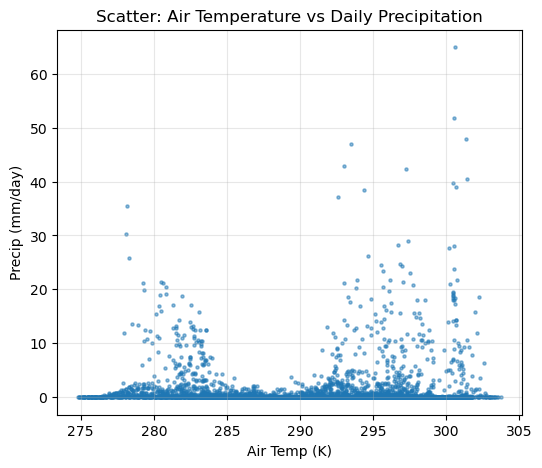

In [33]:
# plot scatter
air_vals = merged.air_temperature.isel(time=0).values
precip_vals = merged.daily_precip.isel(time=0).values

plt.figure(figsize=(6, 5))
plt.scatter(air_vals, precip_vals, s=5, alpha=.5)
plt.xlabel("Air Temp (K)")
plt.ylabel("Precip (mm/day)")
plt.title(f"Scatter: Air Temperature vs Daily Precipitation")
plt.grid(True, alpha=.3)
plt.show()

In [23]:
# save
merged.to_netcdf("../US_air-temp_daily-precip.nc")